# <font color='blue' size=20>SPS Jupyter Notebook v1.0</font>

#  <font color='red'>GENERAL SETUP</font>

#### Loading Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random
from numpy.polynomial import Polynomial

from sklearn import preprocessing
from IPython.display import clear_output, display

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### Functions

In [2]:
# Function of Serge
# Transforms a dictionary to two X, Y list
# Useful for dictionaries with kids as key and tuple of values needed
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

# Function of Serge
# Useful for neural network, transforms 5 to [0,0,0,0,0,1,0,0],
# Not perfect yet
# input i = 5, maxi = 7.
def mabc_to_arr(i, maxi):
    lb = preprocessing.LabelBinarizer()
    lb.fit(list(range(0, maxi)))
    return (lb.transform([i])[0])


#### Importing Data

In [3]:
rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

#### Deleting warmup from rr and m

In [4]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

#### Previewing data

In [5]:
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


In [6]:
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


#  <font color='red'>CRAFTED DATAFRAMES</font>

#### rr_data_time contains 'real_time' which resets per child and runs from 0 to 240.
#### python_tijd was dropped too.

In [7]:
rr_data_time = rr_data

subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]
children_ids = set(subdata['ID'])

times = []

for percent, child_id in enumerate(children_ids):
    child_frame = rr_data.loc[subdata['ID'] == child_id]
    mintime = child_frame['python_tijd'].min()
    fixedtime = child_frame['python_tijd'] - mintime
    times.append(fixedtime.values)
    
    # so you know how long it takes
    clear_output(wait=True)
    print(percent, " percent loading")
    
realtimes = [item for sublist in times for item in sublist]
rr_data_time.insert(4, 'real_time', realtimes)
rr_data_time.drop(columns=['python_tijd'])
clear_output(wait=True)

95  percent loading


#### rr_221100 contains 'time_resetted_per_round' which resets per child  per round.  <br> It also makes sure that the rows are ordered by level as follows (221100)

In [8]:
rr_221100 = pd.DataFrame()

newtimelist = []
newlevellist = []

for percent, child_id in enumerate(children_ids):
    child_frame = rr_data_time.loc[rr_data_time['ID'] == child_id]

    level_00_1 = child_frame.loc[(child_frame['snelheid'] == 0.4) & (child_frame['times_level_played_before'] == 1)]
    level_00_2 = child_frame.loc[(child_frame['snelheid'] == 0.4) & (child_frame['times_level_played_before'] == 2)]
    level_11_1 = child_frame.loc[(child_frame['snelheid'] == 0.6) & (child_frame['times_level_played_before'] == 1)]
    level_11_2 = child_frame.loc[(child_frame['snelheid'] == 0.6) & (child_frame['times_level_played_before'] == 2)]
    level_22_1 = child_frame.loc[(child_frame['snelheid'] == 0.8) & (child_frame['times_level_played_before'] == 1)]
    level_22_2 = child_frame.loc[(child_frame['snelheid'] == 0.8) & (child_frame['times_level_played_before'] == 2)]

    level_00 = list(level_00_1['real_time'] - level_00_1['real_time'].min()) + (list(level_00_2['real_time'] - level_00_2['real_time'].min()))
    level_11 = list(level_11_1['real_time'] - level_11_1['real_time'].min()) + (list(level_11_2['real_time'] - level_11_2['real_time'].min()))
    level_22 = list(level_22_1['real_time'] - level_22_1['real_time'].min()) + (list(level_22_2['real_time'] - level_22_2['real_time'].min()))

    newtimelist += level_00 + level_11 + level_22
    
    rr_221100 = rr_221100.append(level_00_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_00_2, ignore_index = True)
    rr_221100 = rr_221100.append(level_11_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_11_2, ignore_index = True)
    rr_221100 = rr_221100.append(level_22_1, ignore_index = True)
    rr_221100 = rr_221100.append(level_22_2, ignore_index = True)
    
    # so you know how long it takes
    clear_output(wait=True)
    print(percent, " percent loading")
    
rr_221100.insert(4, 'time_resetted_each_round', newtimelist) 


95  percent loading


#  <font color='red'>PLOTS</font>

#### PLOT 1: Correlation between MABC and average costheta

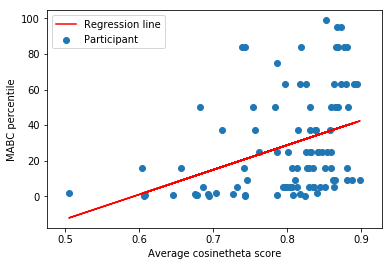

In [9]:
# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)

avg_ct, mabc = dict_to_x_y(subdata_dictionary)

# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


#### PLOT 2: Correlation between MABC and average jerk

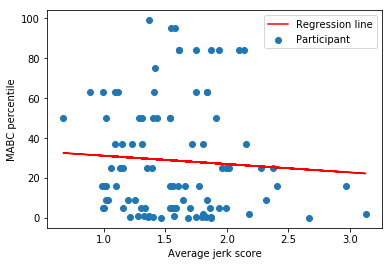

In [10]:

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
    
avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


#### PLOT 3: Correlation between average costheta and rounds

Average costheta per round for all kids:
   level  costheta
0      0  0.814482
1      1  0.800522
2      2  0.781877
[0.814481824505863, 0.8005219329437955, 0.7818773117634136]


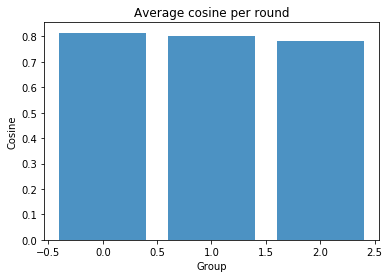

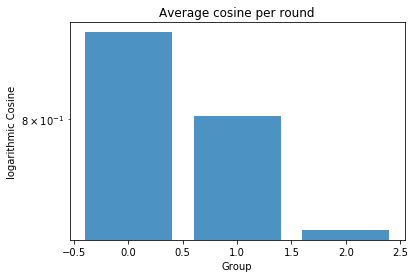

In [11]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print("Average costheta per round for all kids:")
print(rr_221100.groupby('level', as_index=False)['costheta'].mean())
print(list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['level'])
cos_rounds = list(rr_221100.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

In [12]:
#### PLOT 4: ... 

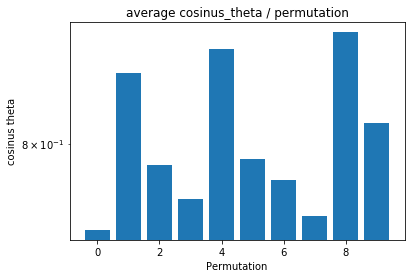

In [13]:
# BAR CHART average cosinus_theta / permutation
permutations = sorted(rr_data['permutation'].unique())

means = []
for p in permutations:
    thispermutation = rr_data.loc[rr_data['permutation'] == p]
    means.append(thispermutation['costheta'].mean())
    
    
plt.bar(permutations, means, log=True)
plt.xlabel('Permutation')
plt.ylabel('cosinus theta')
plt.title('average cosinus_theta / permutation')
plt.savefig('plots/cosine_permutation.png', dpi=100)
plt.show()

#### INFO 5: Avarage age of participants

In [14]:
## get dataframe with only IDs for Average age
ids = rr_data['ID'].unique()
rr_data_id = rr_data.groupby('ID').first()
ages = list(rr_data_id['age_precise'])
print('The average age of all participants is {}'.format(np.mean(ages)))

percs = list(rr_data_id['mabc_percentile_score'])

The average age of all participants is 7.829102126212949


#### PLOT 6: Pie charts of the genders

Text(0.5,1,'Gender distribution')

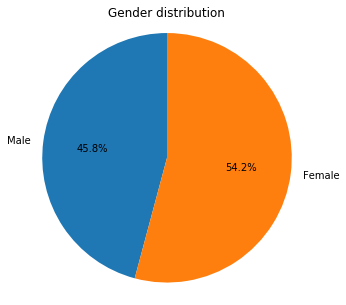

In [15]:
# pie chart of genders
genderlist = list(rr_data_id.groupby('gender').size())
labels = 'Male', 'Female'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(genderlist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Gender distribution')
# uncomment for save:
# fig1.savefig('plots/gender_pie.png', dpi=100)



#### PLOT 6: Pie charts of the MABC

Text(0.5,1,'mABC test result')

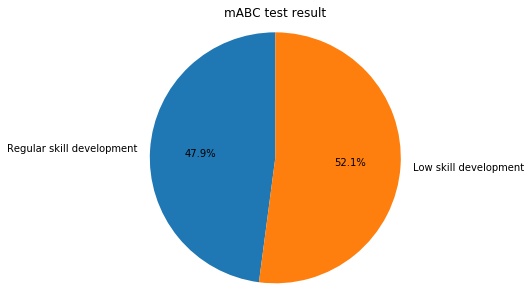

In [16]:
# pie chart of MABC score
abclist = list(rr_data_id.groupby('mabc_binary_score').size())
labels = 'Regular skill development', 'Low skill development'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(abclist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('mABC test result')
# uncomment for save:
# fig1.savefig('plots/mABC_pie.png', dpi=100)

#### PLOT 7: Pie charts of the MABC

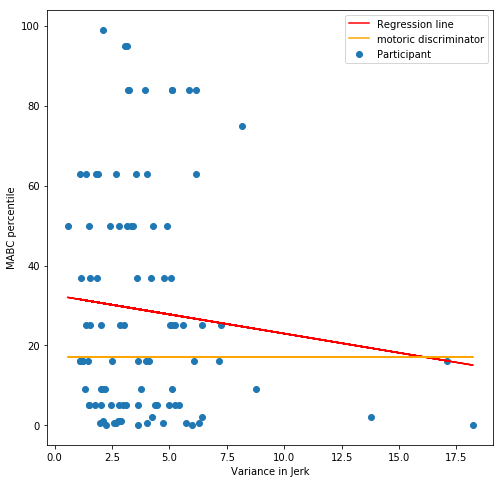

In [17]:
# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    var_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].var()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (var_jerk, mabc_perc)

var_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(var_jerk, mabc)
var_jerk_slope = [i * slope for i in var_jerk]

# scatter plot with mabc
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(var_jerk, mabc, label='Participant')
plt.plot(var_jerk, intercept + var_jerk_slope, 'r', label='Regression line')
plt.plot(var_jerk, [17 for i in range(len(var_jerk))], 'orange', label='motoric discriminator')
plt.xlabel("Variance in Jerk")
plt.ylabel("MABC percentile")
plt.legend()

#### Plot 8: Variance in Jerk in relation to speed

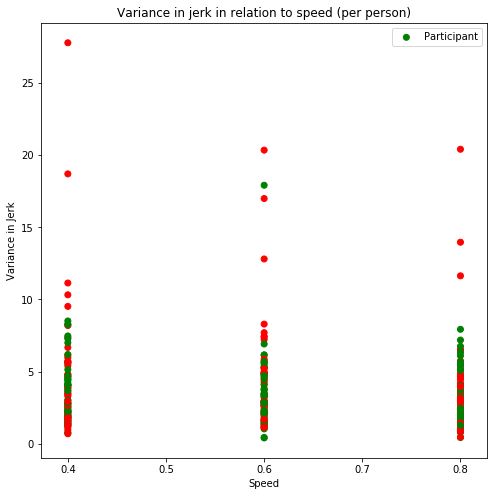

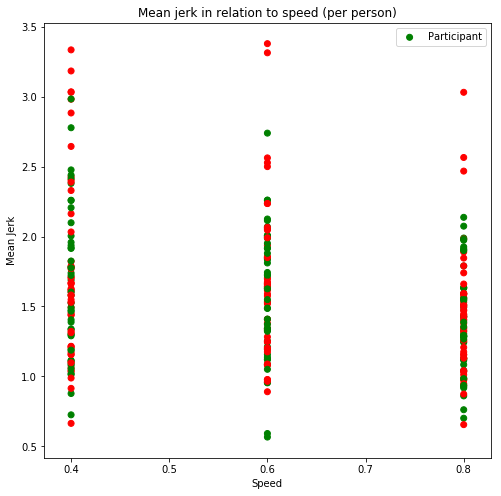

In [18]:
# create a dataframe containing this data
subdata_jerk_speed = rr_data[['ID', 'jerk', 'mabc_binary_score', 'snelheid', 'round']]

speedset = set(subdata_jerk_speed['snelheid'])


subdata_jerk_speed.head(10)


var_jerk_list = []
mean_jerk_list = []
speed_list = []
mabc_list = []

# onderpresterende kinderen reacting to snelheid en jerk
for child_id in children_ids:
    mabc = subdata_jerk_speed.loc[subdata_jerk_speed['ID'] == child_id]['mabc_binary_score'].mean()
    for speed in speedset:
        var_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].var()
        mean_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].mean()
#         print(child_id, "has", mean_jerk, var_jerk, " on speed", speed, ". His MABS is:", mabc)
        speed_list.append(speed)
        var_jerk_list.append(var_jerk)
        mean_jerk_list.append(mean_jerk)
        mabc_list.append(mabc)
#     print()

color_list = ['green' if int(i) is 0 else 'red' for i in mabc_list]

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(speed_list, var_jerk_list, color=color_list, label='Participant')
plt.title("Variance in jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Variance in Jerk")
plt.show()

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(speed_list, mean_jerk_list, color=color_list, label='Participant')
plt.title("Mean jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Mean Jerk")
plt.show()


#### Plot 9: ....

     round  costheta
0  level_A  0.840348
1  level_B  0.812286
2  level_C  0.782614
3  level_D  0.783407
4  level_E  0.789382
5  level_F  0.785403
[0.8403480702396885, 0.8122860235096364, 0.7826141749435335, 0.7834074690478088, 0.7893822278971558, 0.7854031804682886]


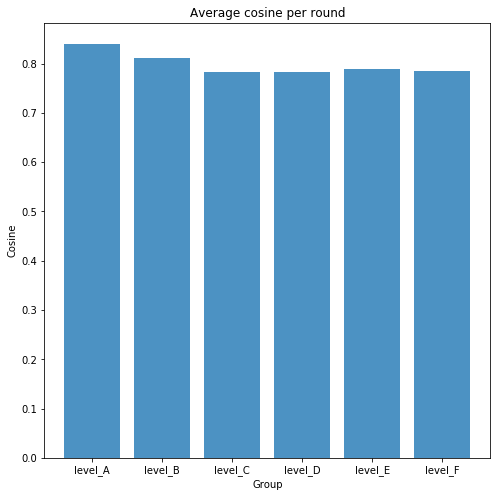

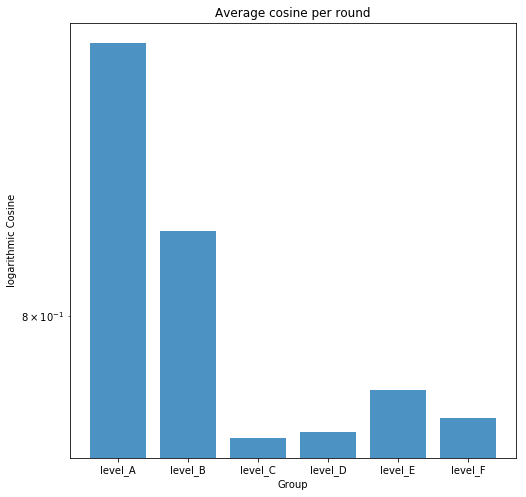

In [19]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print(rr_data.groupby('round', as_index=False)['costheta'].mean())
print(list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['round'])
cos_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

#### Plot 10: Mean and var of cosine per level

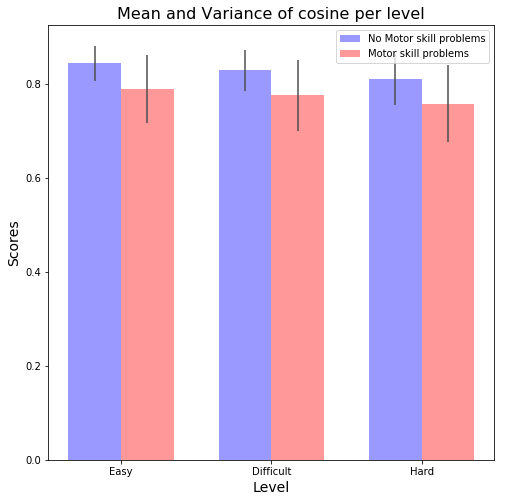

<Figure size 576x432 with 0 Axes>

In [20]:
# drop ID 255
rr_data_dropped = rr_data
rr_data_dropped = rr_data_dropped.drop(rr_data[rr_data.ID == 255].index)

# divide dataset based on mABC score
normaal = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 0]
gestoord = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 1]

# get average cosines of normal kids
normaal_avgcos = list(normaal.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get average cosines of gestoorde kids
gestoord_avgcos = list(gestoord.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get variance of cosines of normal en gestoorde kids
normaal_var = list(normaal.groupby('level', as_index=False)['costheta'].var()['costheta'])
gestoord_var = list(gestoord.groupby('level', as_index=False)['costheta'].var()['costheta'])

# plot beautiful barchart
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = 3
fig, ax = plt.subplots()
plt.figure(figsize=(8,6))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, normaal_avgcos, bar_width,
                alpha=opacity, color='b',
                yerr=normaal_var, error_kw=error_config,
                label='No Motor skill problems')

rects2 = ax.bar(index + bar_width, gestoord_avgcos, bar_width,
                alpha=opacity, color='r',
                yerr=gestoord_var, error_kw=error_config,
                label='Motor skill problems')

ax.set_xlabel('Level', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mean and Variance of cosine per level', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Easy', 'Difficult', 'Hard'))
ax.legend()
# uncomment for save
# fig.savefig('plots/mean_var_cos_per_level.png', dpi=100)

plt.show()

#### Plot 11: Correlation between rr & m game

The average of children without motor skill problems : 0.2940828632338094
The average of children with motor skill problems : 0.3221141618978073


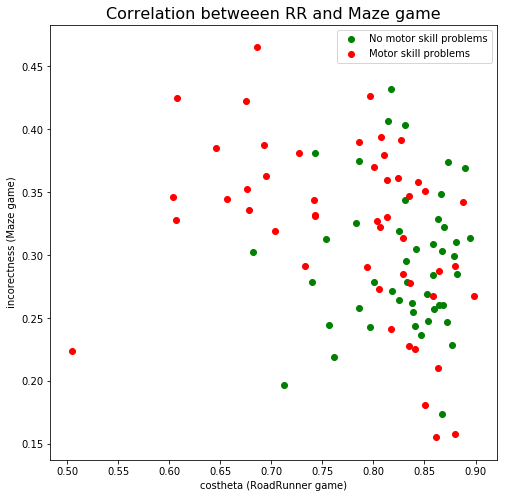

In [21]:
# difference Roadrunner en maze lilcasp
# avg costheta roadrunner participants
rr_costheta_normaal = list((normaal.groupby('ID', as_index=False)['costheta'].mean()['costheta']))
rr_costheta_gestoord = list((gestoord.groupby('ID', as_index=False)['costheta'].mean()['costheta']))

# split data of maze 
normaal_m = m_data[m_data['mabc_binary_score'] == 0]
gestoord_m = m_data[m_data['mabc_binary_score'] == 1]

m_incorrect_normaal = list((normaal_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))
m_incorrect_gestoord = list((gestoord_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))

print('The average of children without motor skill problems : {}'.format(np.mean(m_incorrect_normaal)))
print('The average of children with motor skill problems : {}'.format(np.mean(m_incorrect_gestoord)))

# plot this babe
plt.scatter(rr_costheta_normaal, m_incorrect_normaal, color='green', label='No motor skill problems')
plt.scatter(rr_costheta_gestoord, m_incorrect_gestoord, color='red', label='Motor skill problems')
plt.title('Correlation betweeen RR and Maze game', fontsize=16)
plt.xlabel('costheta (RoadRunner game)')
plt.ylabel('incorectness (Maze game)')
plt.legend()
# plt.savefig('plots/correlation_RR_M.png', dpi=100)
plt.show()

#  <font color='red'>Machine Learning</font>

#### Splits all rows in training data, validation data and testing data. 

In [22]:
# shuffle this list
shuffled_kids = random.sample(list(children_ids), len(list(children_ids)))

# 56 kinderen training
# 20 kinderen
# 20 kinderen
training_kids = shuffled_kids[:56]
val_kids = shuffled_kids[56:76]
testing_kids = shuffled_kids[76:96]

rr_training_data = rr_data.loc[rr_data['ID'].isin(training_kids)]
rr_val_data = rr_data.loc[rr_data['ID'].isin(val_kids)]
rr_testing_data = rr_data.loc[rr_data['ID'].isin(testing_kids)]

#### Applies polynomial regression on each kid on the round with the 0.4 speed (level_2). <br> Possible to plot. <br> Creates array with X as training data (polynomial regression coordinates) and Y is just the label (problem or not)

In [27]:
X = []
Y = []

for child_id in children_ids:
    child_frame = rr_221100.loc[(rr_221100['ID'] == child_id) & (rr_221100['snelheid'] == 0.4)]
    
    child_frame_1 = child_frame.loc[(child_frame['times_level_played_before'] == 1)]
    times_1 = list(child_frame_1['time_resetted_each_round'])
    costheta_1 = list(child_frame_1['costheta'])
    
    child_frame_2 = child_frame.loc[(child_frame['times_level_played_before'] == 2)]
    times_2 = list(child_frame_2['time_resetted_each_round'])
    costheta_2 = list(child_frame_2['costheta'])
    
    mabc_percentile = list(child_frame['mabc_percentile_score'].head(1))[0]
    mabc_binary = list(child_frame['mabc_binary_score'].head(1))[0]
    
    p = Polynomial.fit(times_1, costheta_1, 7)
    values_polynomial = np.array(p.linspace()[0])
    
    X.append(values_polynomial)
    Y.append(mabc_to_arr(int(mabc_binary), 3))
    
#     # UNCOMMENT TO PLOT
#     if list(child_frame['mabc_binary_score'].head(1))[0]:
#         color = 'red'
#         label = 'low'
#         weight = (100 - mabc_percentile)/100
#     else:
#         color = 'green'
#         label = 'well'
#         weight = mabc_percentile/100
    
#     plt.plot(*p.linspace(), linewidth=4, color=color, label="polyfit")
#     plt.rcParams["figure.figsize"] = (17, 14)
#     plt.plot(times_1, costheta_1, color, alpha=weight, label="first round of a {}-performing child (MABC {})".format(label, mabc_percentile))
#     plt.plot(times_2, costheta_2, color, alpha=weight, label="second round of {}-performing child (MABC {})".format(label, mabc_percentile))
#     plt.title('0.4 Speed rounds of child {}'.format(child_id))
#     plt.xlabel('Time in seconds')
#     plt.ylabel('Cosinetheta Score')
#     plt.legend()
#     plt.show()
    
X = np.array(X)
Y = np.array(Y)

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(96,96,3), max_iter=1000, alpha=0.0002,
                     solver='adam', activation='identity', verbose=1,tol=0.0000000000001)
clf.fit(np.array(X), np.array(Y))

# y_pred = clf.predict(np.array(X))

Iteration 1, loss = 10.76900645
Iteration 2, loss = 15.93945429
Iteration 3, loss = 20.87655528
Iteration 4, loss = 17.00859882
Iteration 5, loss = 12.35302093
Iteration 6, loss = 9.18452025
Iteration 7, loss = 4.28880058
Iteration 8, loss = 6.63156196
Iteration 9, loss = 8.57019809
Iteration 10, loss = 7.84172368
Iteration 11, loss = 5.79614680
Iteration 12, loss = 1.91851383
Iteration 13, loss = 4.15010446
Iteration 14, loss = 5.38687265
Iteration 15, loss = 6.67371631
Iteration 16, loss = 6.14073983
Iteration 17, loss = 4.49283429
Iteration 18, loss = 2.62121411
Iteration 19, loss = 2.28338246
Iteration 20, loss = 3.98185026
Iteration 21, loss = 4.34105031
Iteration 22, loss = 3.68267538
Iteration 23, loss = 1.94724213
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='identity', alpha=0.0002, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(96, 96, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-13,
       validation_fraction=0.1, verbose=1, warm_start=False)